# Camunda 8 Workers:
## Power Consumption at Startup, Stop And Idle
This measurement is based on the shell-script ```start_worker_script_sequential.sh``` in ```shell-scripts/```

Scrape interval is 10 seconds

### Worker settings
maxJobsActive: 32
pollInterval: 2s
timeout: 45s
requestTimeout: 60s

## Concept
Measurement window is **5 minutes**, each minute should be looked at seperately:
- **Min1** Starting the worker
- **Min2** Idle with started worker # 1
- **Min3** Idle with started worker # 2
- **Min4** Shutting down worker
- **Min5** Idle before starting next worker

### Idle
- Considering the average of all: 
    - **Min2** / **BASE_WORKERS** + 1 
    - **Min3** / **BASE_WORKERS** + 1 
    - **Min5** / **BASE_WORKERS**

*11.12.23, Author: Jan Wittrowski*

Cheatsheet

```df.loc[row, col]```

Sum up the first three cells of each column
sum_first_three = df.iloc[:3].sum()


## Importing, Preparation

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

LOG_PATH = "shell-scripts/logs/"
LOG_NAME = "2023-12-13-08-16-00-baseworkers=0-count=30-STARTS"

#read first CSV
rawdata = pd.read_csv("CSV/Start_Stop_Sequential_2023-12-13-08-19-00 Pod_Process Power Consumption (W) in Namespace_ All-data-as-joinbyfield-2023-12-14 17_24_12.csv", 
                     header=1, # which row contains column headers
                     index_col=0   ) # which column contains labels

#read starting times
with open(LOG_PATH+LOG_NAME, "r") as file:
    start_times = file.readlines()

# remove newline-character, 
for i, time in enumerate(start_times):
    start_times[i] = time[:-1]


# start_times

In [75]:
# remove irrelevant columns: 

columns_to_keep = rawdata.columns[~rawdata.columns.str.contains('OTHER|measuring-endpoints|monitoring|console-worker|tasklist|operate|bpmndeployment|processstart|elasticsearch|connectors|load-controller')]
data = rawdata.loc[:, columns_to_keep]

data

,camunda-platform-zeebe-0 / camunda8 / PKG,camunda-platform-zeebe-gateway-5ff76496c4-vf4q5 / camunda8 / PKG,coredns-77ccd57875-qkp4q / kube-system / PKG,helm-install-traefik-crd-hzktt / kube-system / PKG,helm-install-traefik-ncp5n / kube-system / PKG,local-path-provisioner-957fdf8bc-jnlfw / kube-system / PKG,metrics-server-648b5df564-msqlc / kube-system / PKG,svclb-traefik-5671c552-795qx / kube-system / PKG,traefik-768bdcdcdd-4f8ms / kube-system / PKG,system_processes / system / PKG,...,restworkerjava-dfbc8756-ln9ms / worker / DRAM,restworkerjava-dfbc8756-mb9l6 / worker / DRAM,restworkerjava-dfbc8756-nblzj / worker / DRAM,restworkerjava-dfbc8756-pbwzt / worker / DRAM,restworkerjava-dfbc8756-rqf8k / worker / DRAM,restworkerjava-dfbc8756-t6kb8 / worker / DRAM,restworkerjava-dfbc8756-t6mrd / worker / DRAM,restworkerjava-dfbc8756-xpz7n / worker / DRAM,restworkerjava-dfbc8756-zjg5w / worker / DRAM,restworkerjava-dfbc8756-zxmb6 / worker / DRAM
Time,,,,,,,,,,,,,,,,,,,,,
2023-12-13 08:19:00,0.915,0.388,0.249,0.233,0.233,0.236,0.250,0.467,0.236,1.180,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-13 08:19:10,0.800,0.314,0.185,0.171,0.171,0.173,0.185,0.342,0.173,3.510,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-13 08:19:20,3.300,0.857,0.240,0.173,0.173,0.181,0.240,0.346,0.176,5.590,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-13 08:19:30,1.120,0.436,0.251,0.229,0.229,0.232,0.260,0.457,0.232,3.470,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-13 08:19:40,0.616,0.271,0.181,0.171,0.171,0.173,0.180,0.342,0.172,0.793,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-13 10:48:20,0.916,0.344,0.197,0.177,0.177,0.181,0.195,0.355,0.179,0.966,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-13 10:48:30,1.490,0.515,0.262,0.235,0.235,0.239,0.268,0.470,0.238,1.380,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-13 10:48:40,0.766,0.305,0.190,0.176,0.176,0.179,0.189,0.352,0.177,0.779,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [76]:
# rename 'kube-system' names to avoid double picking with 'system' namespace

new_columns = []
for i, col in enumerate(data.columns):
    if 'kube-system' in col:
        new_columns.append(col.replace('kube-system', 'kube'))
    else:
        new_columns.append(col)

data.columns = new_columns

In [77]:
# extract measurements. use list of start_times and measurements_per_cycle (amount of datapoints)
def split_data_into_cycles(df, start_times, measurements_per_cycle):
    cycles = []
    # Select all rows belonging to a cycle
    for item in start_times:
        temp = pd.DataFrame()

        index = df.index.get_loc(item)

        temp = df.iloc[index:index + measurements_per_cycle,:]
        temp = temp.dropna(how="all", axis=1)

        cycles.append(temp)
    
    return cycles;

# every Cycle with 30 measurements is 1 entry in list
STEPS_PER_CYCLE = 30 # 5 Min * 6 Scrapes/Min

cycles = split_data_into_cycles(data, start_times,STEPS_PER_CYCLE)

In [78]:
# read namespaces from columns. 
# This relies on grafana CSV-outputs using '/' as a divider: "pod / namespace / domain"
def extract_namespaces(df):
    namespaces = []
    for col in df.columns:
        split_col = col.split('/')
        if len(split_col) > 1:
            namespace = split_col[1].strip()
            if namespace not in namespaces:
                namespaces.append(namespace)
    return namespaces;


In [79]:
# for each cycle, group all pods from namespace
def group_namespaces_per_cycle(cycles):
    grouped_cycles = []
    namespaces = extract_namespaces(data)

    for item in cycles:
        temp = pd.DataFrame()

        for namespace in namespaces:
            namespace_cols = [col for col in item.columns if namespace in col]
            temp[namespace] = item[namespace_cols].sum(axis=1)  

        grouped_cycles.append(temp)
    
    return grouped_cycles;


cycles_by_namespace = group_namespaces_per_cycle(cycles)

In [80]:
# create relative timestamps

def create_relative_timestamps(min, max, interval):
    elapsed_times = []
    for i in range(min,int(max/interval)):
        s = i * interval % 60
        m = int(i / (60 / interval))
        elapsed_times.append("{:02d}:{:02d}".format(m,s))

    return elapsed_times;

elapsed_times = create_relative_timestamps(0, 300, 10)

# elapsed_times


In [81]:
# create single dataframe for namespace for better readability
def isolate_namespace_per_cycle(namespace, cycles_list):
    df = pd.DataFrame(index=elapsed_times)
    
    for item in cycles_list:
        temp = item[namespace]
        temp.index = elapsed_times
        
        df[item.index[0]] = temp
    
    return df;

all_camunda_series = isolate_namespace_per_cycle("camunda8", cycles_by_namespace)
all_system_series = isolate_namespace_per_cycle("system", cycles_by_namespace)
all_worker_series = isolate_namespace_per_cycle("worker", cycles_by_namespace)
all_kube_system_series = isolate_namespace_per_cycle("kube", cycles_by_namespace)

<Axes: title={'center': 'System (Full Cycle)'}, xlabel='Time', ylabel='Consumed Power [W]'>

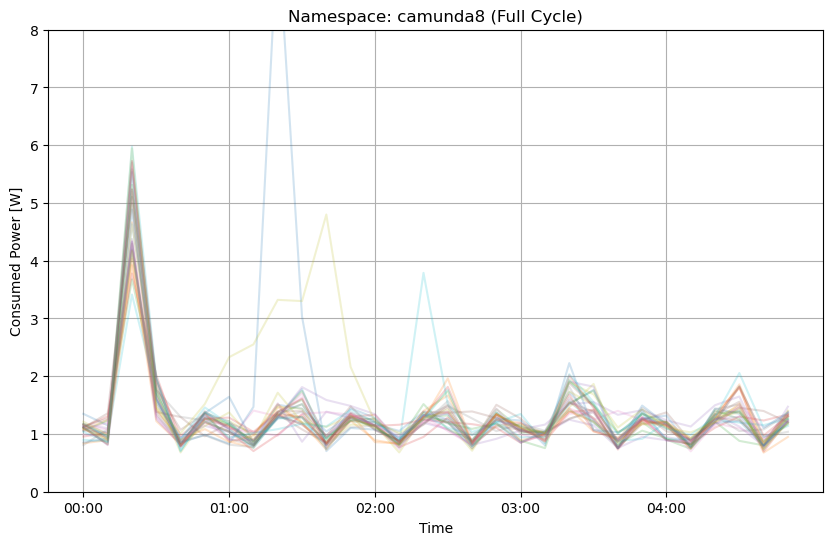

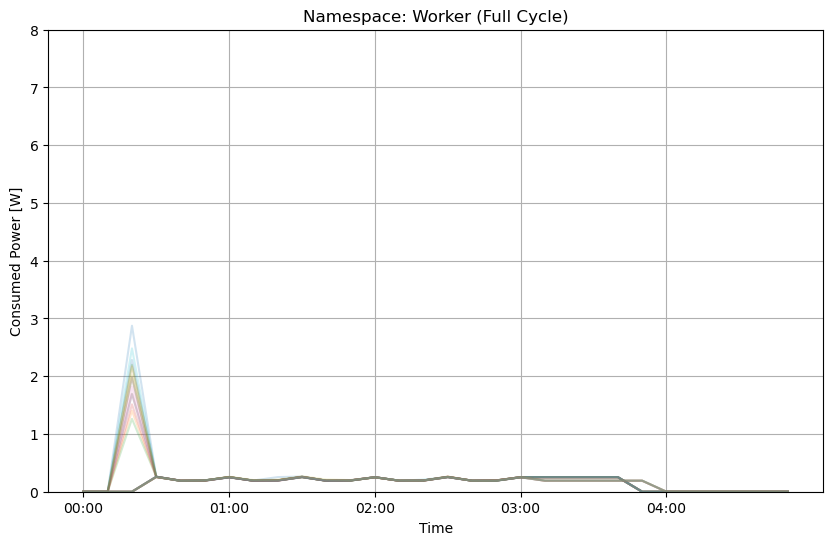

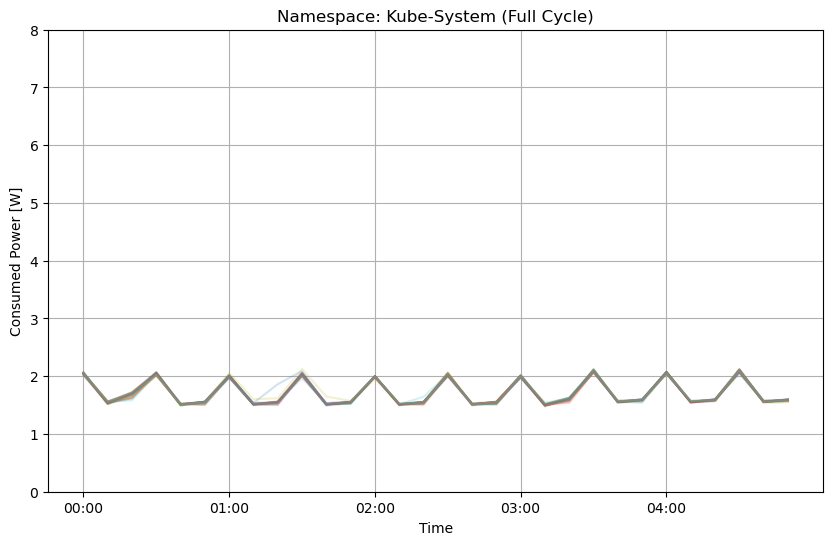

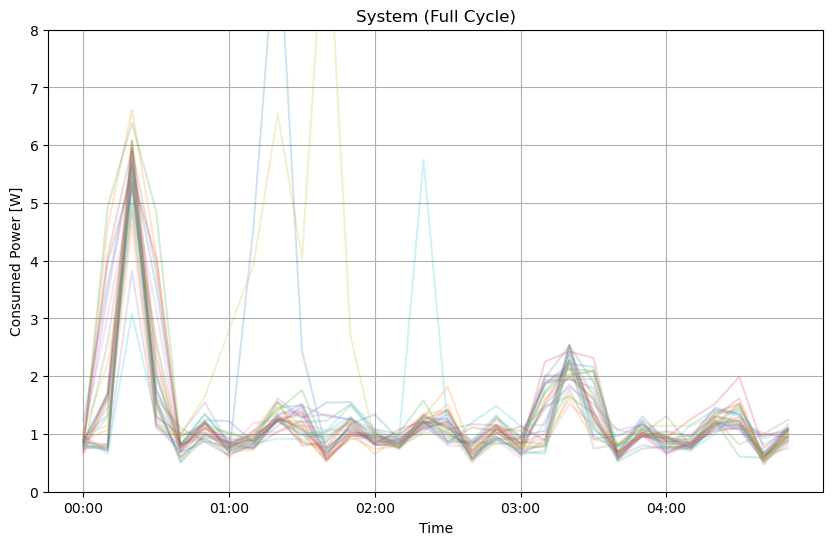

In [97]:
# plot results
ylim=[0,8] 
figsize = [10,6]
alpha=0.2
x_ticks = [0,6,12,18,24]
grid=True

all_camunda_series.plot(legend=False, alpha = alpha, ylim = ylim, figsize = figsize, xticks = x_ticks, grid = grid, title = "Namespace: camunda8 (Full Cycle)", xlabel='Time', ylabel='Consumed Power [W]')
all_worker_series.plot(legend=False, alpha = alpha, ylim = ylim, figsize = figsize, xticks = x_ticks, grid = grid, title = "Namespace: Worker (Full Cycle)", xlabel='Time', ylabel='Consumed Power [W]')
all_kube_system_series.plot(legend=False, alpha = alpha, ylim = ylim, figsize = figsize, xticks = x_ticks, grid = grid, title = "Namespace: Kube-System (Full Cycle)", xlabel='Time', ylabel='Consumed Power [W]')
all_system_series.plot(legend=False, alpha = alpha, ylim = ylim, figsize = figsize, xticks = x_ticks, grid = grid, title = "System (Full Cycle)", xlabel='Time', ylabel='Consumed Power [W]')

## Identifying Outliers

<Axes: title={'center': 'Each Cycle in Minute 5'}>

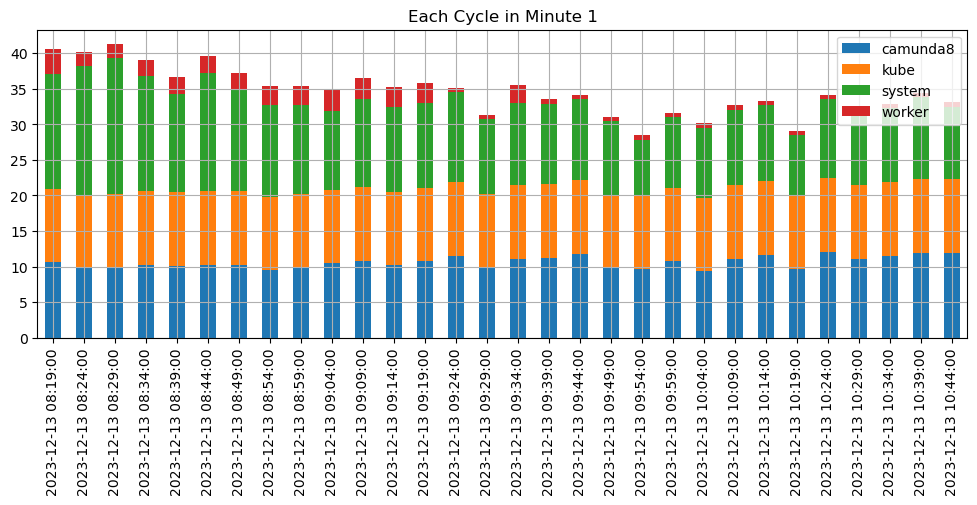

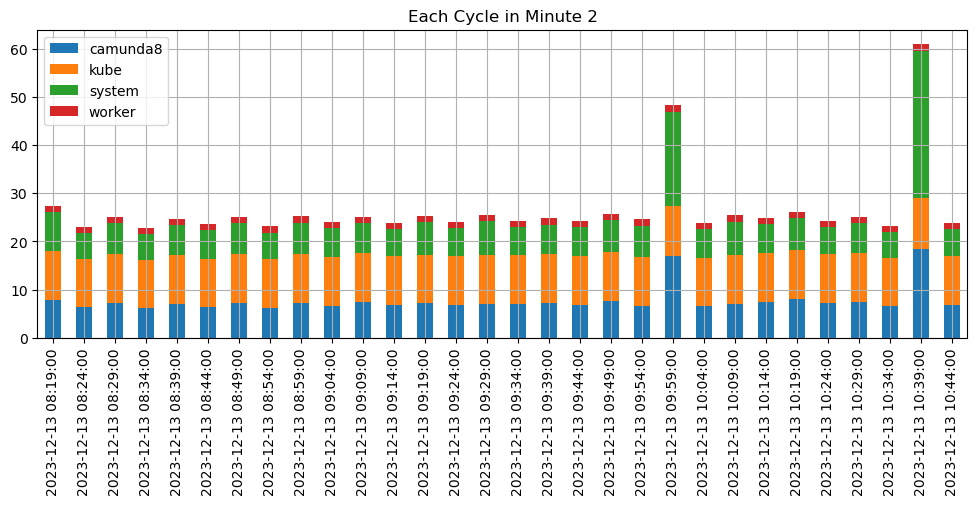

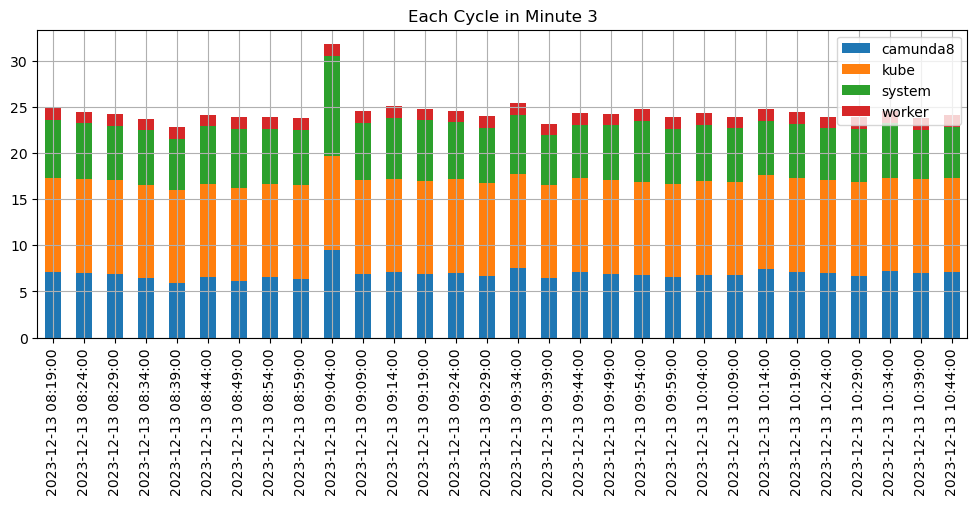

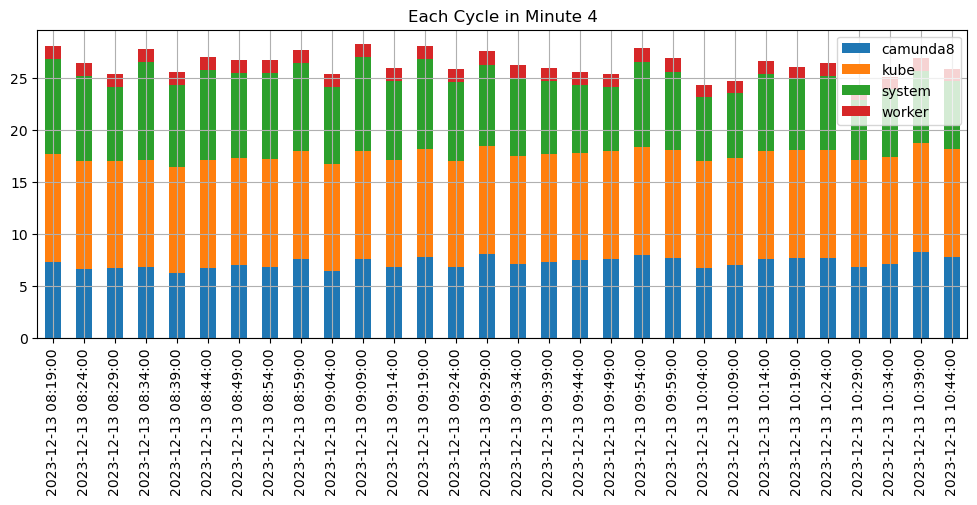

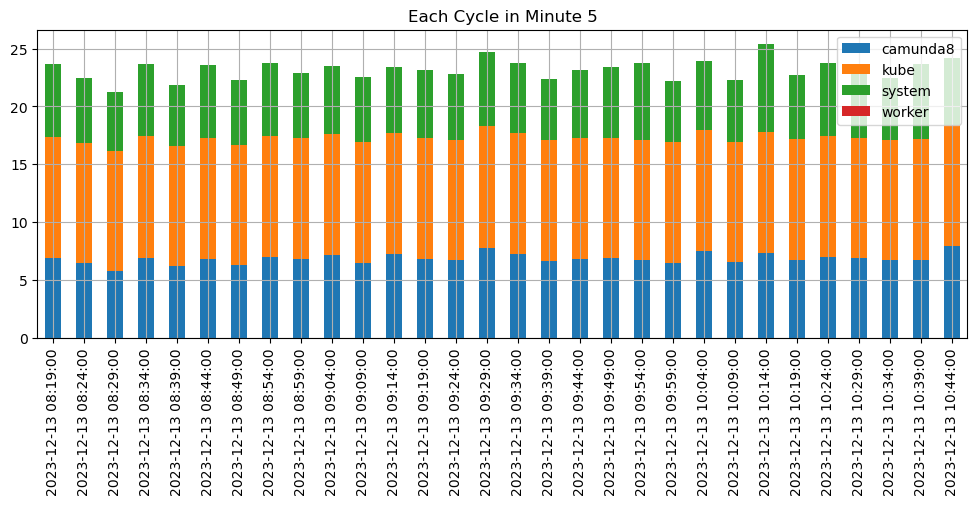

In [83]:
# create sums by minute

def create_min_by_namespace(cycles_by_namespace, min):
    min_by_namespace = pd.DataFrame()
    index=create_relative_timestamps(0,60,10)
    for item in cycles_by_namespace:
        min_by_namespace[item.index[0]] = pd.DataFrame(item.iloc[ (min - 1) * 6 : min * 6 ,:]).sum(axis=0)
        
    min_by_namespace = min_by_namespace.transpose()
    return min_by_namespace

min1_by_namespace = create_min_by_namespace(cycles_by_namespace,1)
min2_by_namespace = create_min_by_namespace(cycles_by_namespace,2)
min3_by_namespace = create_min_by_namespace(cycles_by_namespace,3)
min4_by_namespace = create_min_by_namespace(cycles_by_namespace,4)
min5_by_namespace = create_min_by_namespace(cycles_by_namespace,5)

min1_by_namespace.plot(kind='bar', stacked=True, figsize=[12,4], title= "Start (Min1) Cycle Comparison by Namespace", grid=True)
min2_by_namespace.plot(kind='bar', stacked=True, figsize=[12,4], title= "Idle Worker (Min2) Cycle Comparison by Namespace", grid=True)
min3_by_namespace.plot(kind='bar', stacked=True, figsize=[12,4], title= "Idle Worker (Min3) Cycle Comparison by Namespace", grid=True)
min4_by_namespace.plot(kind='bar', stacked=True, figsize=[12,4], title= "Stop (Min4) Cycle Comparison by Namespace", grid=True)
min5_by_namespace.plot(kind='bar', stacked=True, figsize=[12,4], title= "No Worker (Min5) Cycle Comparison by Namespace", grid=True)

#### Outliers:

**Min1**

- '2023-12-10 05:21:00'
- '2023-12-10 06:01:00'

**Min5**

- '2023-12-10 05:56:00'
- '2023-12-10 03:56:00'

#### Cleaning up

In [84]:
# drop outliers from rawdata
outliers = [
    '2023-12-13 09:59:00', 
    '2023-12-13 10:39:00', 
    '2023-12-13 09:04:00', 
]

start_times_clean = [time for time in start_times if time not in outliers]

In [85]:
cycles_clean = split_data_into_cycles(data, start_times_clean,STEPS_PER_CYCLE)
cycles_by_namespace_clean = group_namespaces_per_cycle(cycles_clean)

all_camunda_series_clean = isolate_namespace_per_cycle("camunda8", cycles_by_namespace_clean)
all_system_series_clean = isolate_namespace_per_cycle("system", cycles_by_namespace_clean)
all_worker_series_clean = isolate_namespace_per_cycle("worker", cycles_by_namespace_clean)
all_kube_system_series_clean = isolate_namespace_per_cycle("kube", cycles_by_namespace_clean)

<Axes: title={'center': 'Each Cycle in Minute 5 - cleaned'}>

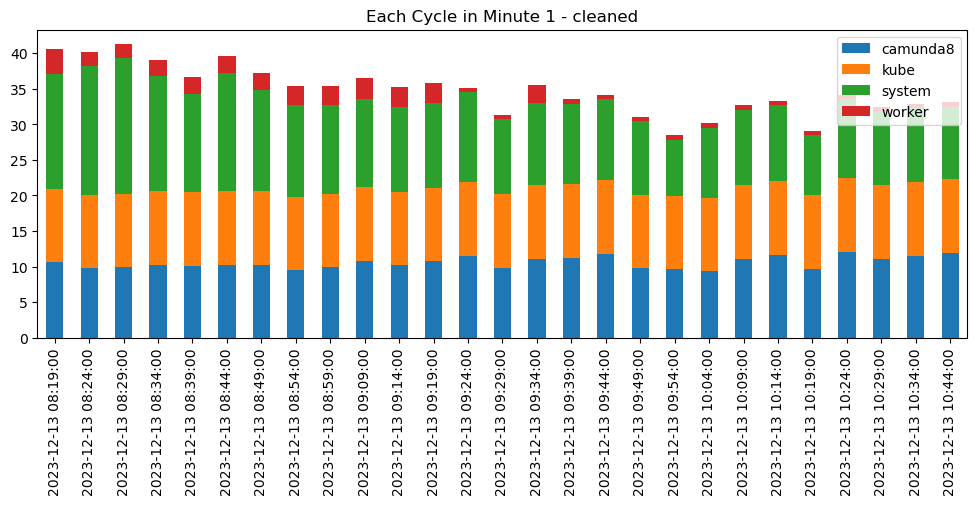

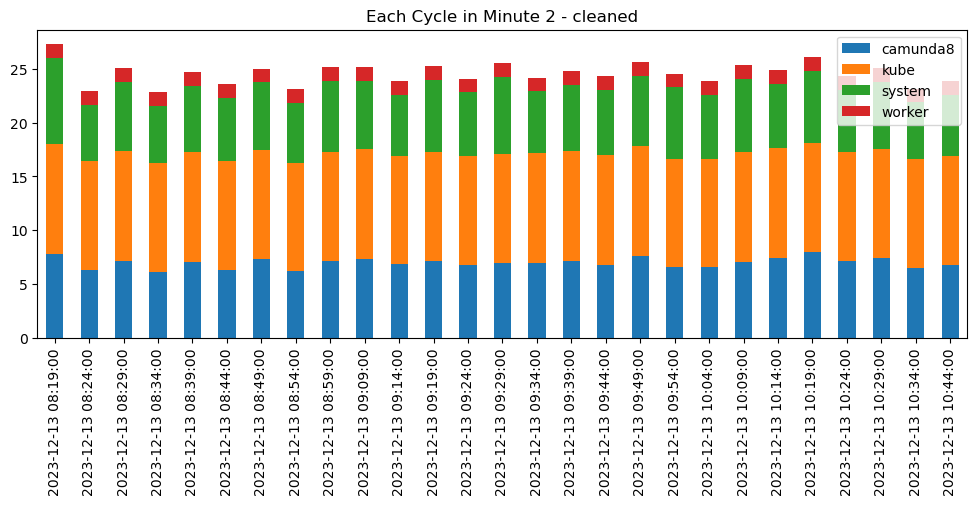

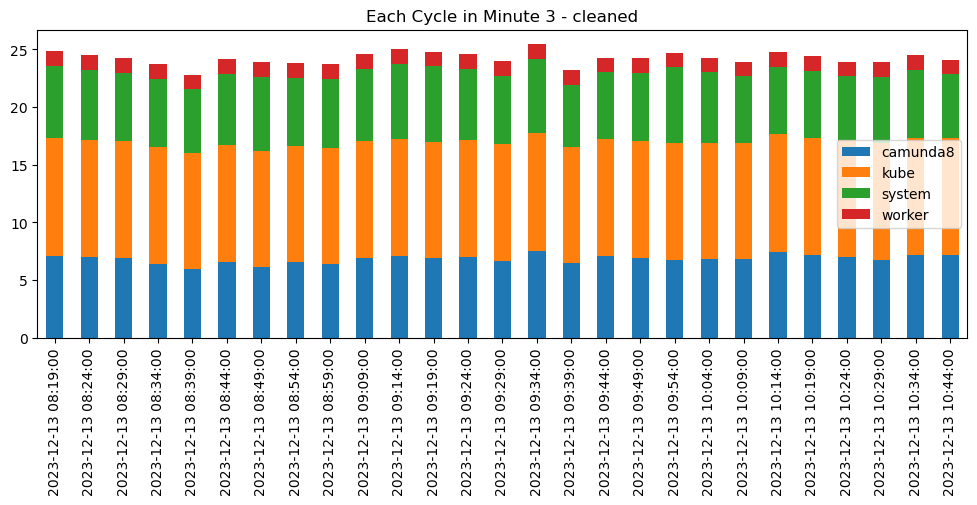

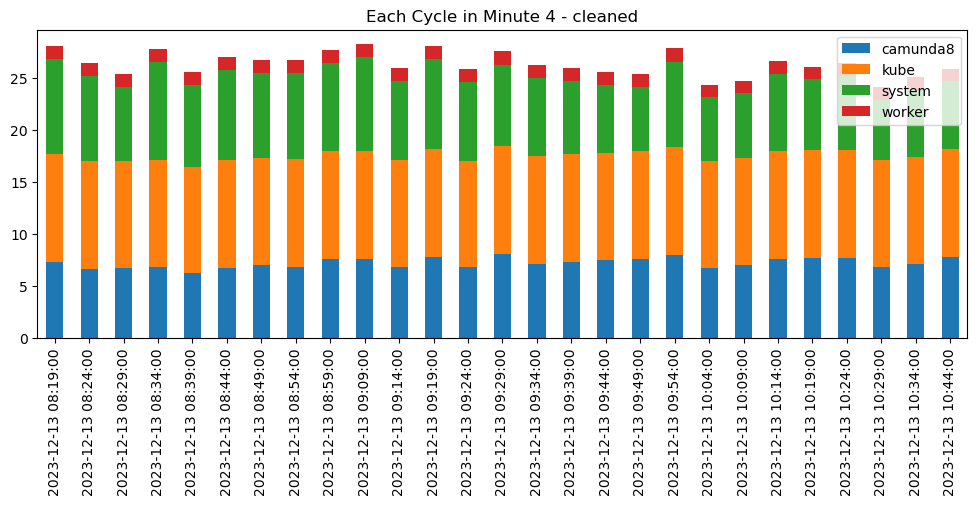

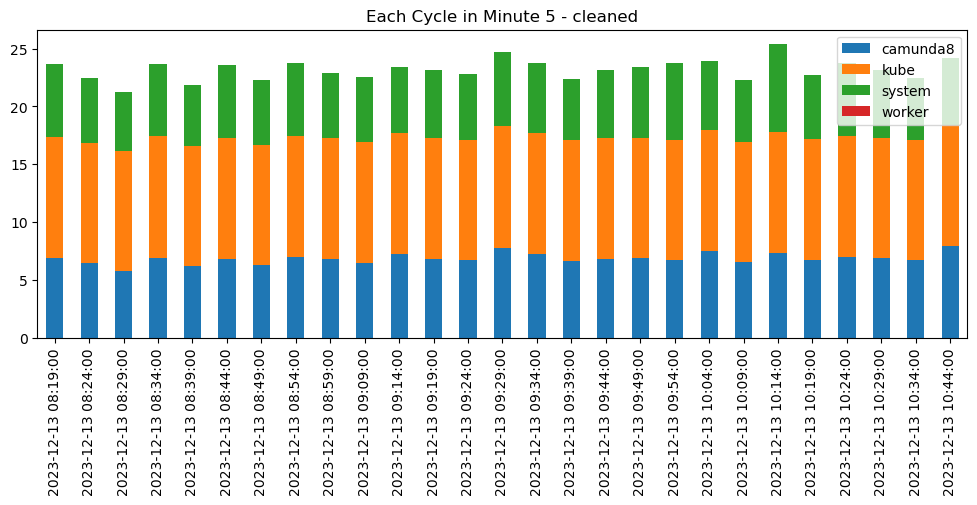

In [86]:
min1_by_namespace = create_min_by_namespace(cycles_by_namespace_clean,1)
min2_by_namespace = create_min_by_namespace(cycles_by_namespace_clean,2)
min3_by_namespace = create_min_by_namespace(cycles_by_namespace_clean,3)
min4_by_namespace = create_min_by_namespace(cycles_by_namespace_clean,4)
min5_by_namespace = create_min_by_namespace(cycles_by_namespace_clean,5)

min1_by_namespace.plot(kind='bar', stacked=True, figsize=[12,4], title= "Each Cycle in Minute 1 - cleaned")
min2_by_namespace.plot(kind='bar', stacked=True, figsize=[12,4], title= "Each Cycle in Minute 2 - cleaned")
min3_by_namespace.plot(kind='bar', stacked=True, figsize=[12,4], title= "Each Cycle in Minute 3 - cleaned")
min4_by_namespace.plot(kind='bar', stacked=True, figsize=[12,4], title= "Each Cycle in Minute 4 - cleaned")
min5_by_namespace.plot(kind='bar', stacked=True, figsize=[12,4], title= "Each Cycle in Minute 5 - cleaned")

<Axes: title={'center': 'System'}, xlabel='Time (Full Cycle) - Outliers removed', ylabel='Consumed Power [W] - cleaned'>

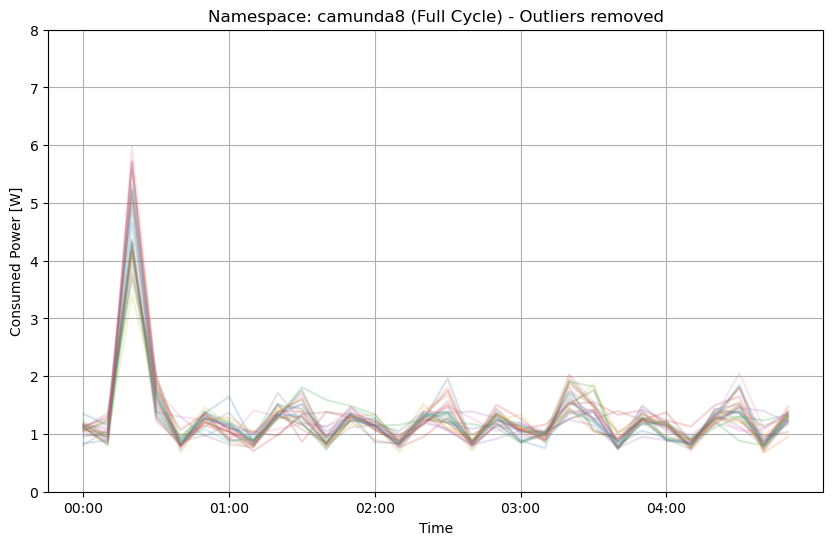

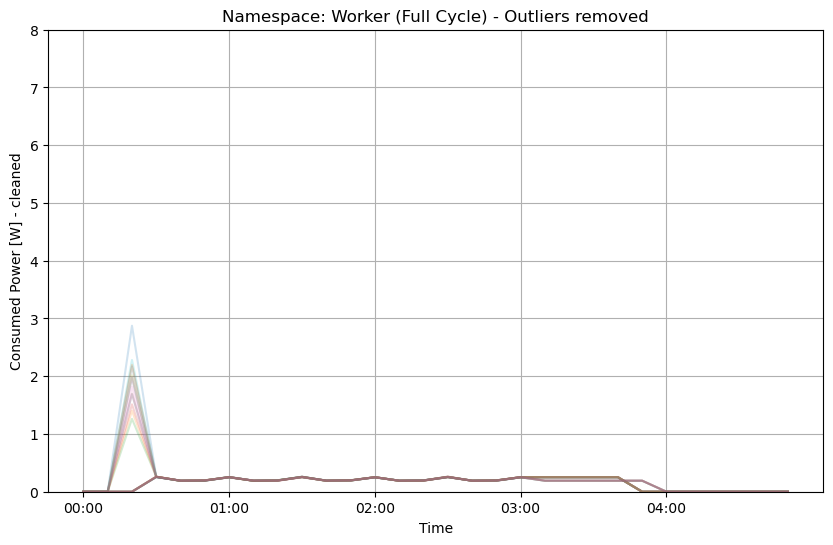

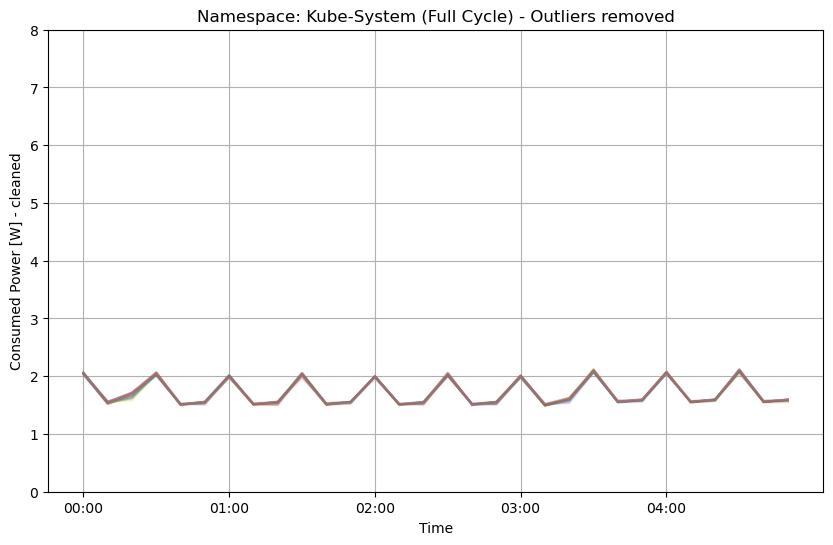

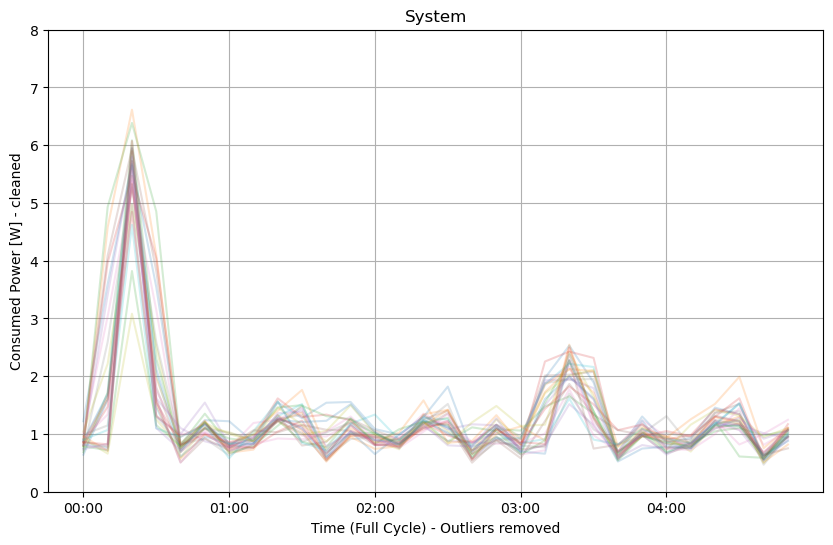

In [96]:
all_camunda_series_clean.plot(legend=False, alpha = alpha, ylim = ylim, figsize = figsize, xticks = x_ticks, grid = grid, title = "Namespace: camunda8 (Full Cycle) - Outliers removed", xlabel='Time', ylabel='Consumed Power [W]')
all_worker_series_clean.plot(legend=False, alpha = alpha, ylim = ylim, figsize = figsize, xticks = x_ticks, grid = grid, title = "Namespace: Worker (Full Cycle) - Outliers removed", xlabel='Time', ylabel='Consumed Power [W] - cleaned')
all_kube_system_series_clean.plot(legend=False, alpha = alpha, ylim = ylim, figsize = figsize, xticks = x_ticks, grid = grid, title = "Namespace: Kube-System (Full Cycle) - Outliers removed", xlabel='Time', ylabel='Consumed Power [W] - cleaned')
all_system_series_clean.plot(legend=False, alpha = alpha, ylim = ylim, figsize = figsize, xticks = x_ticks, grid = grid, title = "System", xlabel='Time (Full Cycle) - Outliers removed', ylabel='Consumed Power [W] - cleaned')

In [88]:
index = [ 'Min1', 'Min2', 'Min3', 'Min4', 'Min5' ]

def create_avg_by_min_series(df, new_index):
    series_avg = df.mean(axis=1)
    temp = pd.Series(index=new_index)
    
    for i in range(0,5):
        temp[i] = series_avg[i * 6 : (i + 1) * 6].sum()

    return temp


avg_by_min = pd.DataFrame(index = index)


avg_by_min['system'] = create_avg_by_min_series(all_system_series_clean, index)
avg_by_min['kube-system'] = create_avg_by_min_series(all_kube_system_series_clean, index)
avg_by_min['camunda8'] = create_avg_by_min_series(all_camunda_series_clean,index)
avg_by_min['worker'] = create_avg_by_min_series(all_worker_series_clean, index)

avg_by_min


,system,kube-system,camunda8,worker
Min1,12.332141,10.368552,10.556807,1.563611
Min2,6.188296,10.154000,6.967663,1.280678
Min3,5.997607,10.129922,6.830444,1.276307
Min4,7.553785,10.335096,7.189237,1.242715
Min5,5.894537,10.448422,6.848593,0.000000


<Axes: title={'center': 'Average Power Consumption by Minute'}, ylabel='Avg Consumed Power [W/Min]'>

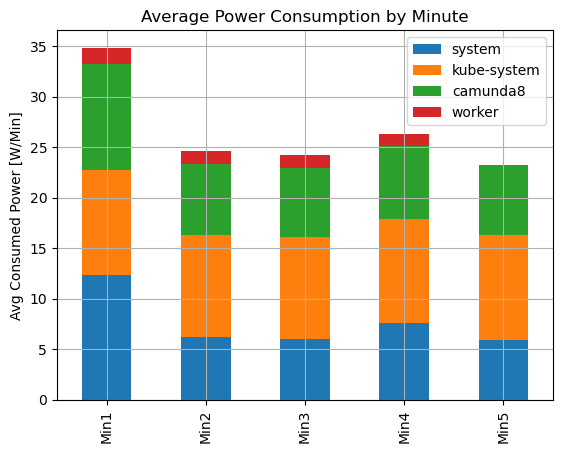

In [89]:
# plot average consumption per minute
# ylim=[0,8] 
figsize = [10,6]
alpha=0.2
grid=True

avg_by_min.plot(
    kind="bar",
    stacked=True,
    title = 'Average Power Consumption by Minute',
    grid=True,
    ylabel='Avg Consumed Power [W/Min]'
)

In [90]:
avg_idle = min5_by_namespace.mean(axis=0)

avg_idle


camunda8     6.848593
kube        10.448422
system       5.894537
worker       0.000000
dtype: float64

### Calculating Idle

**Min5** is running 1 worker, so this will serve as a baseline. Since no operations are being done in 'kube-system' and 'system', disregard namespaces for Idle. **only 'worker' and 'zeebe' remain.**

<Axes: title={'center': 'Difference Avg Min 2-3 to Min 5'}>

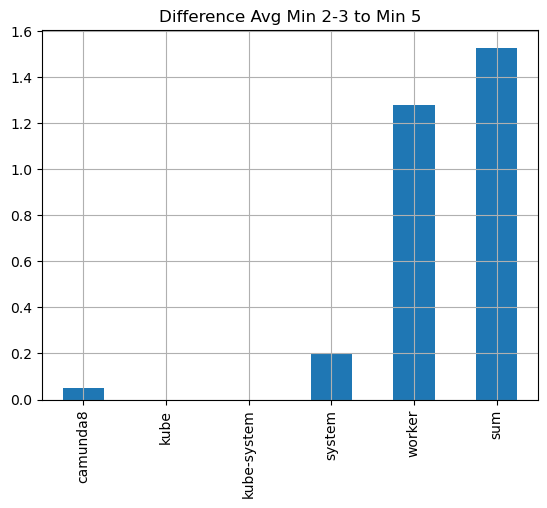

In [91]:
min2_3 = avg_by_min['Min2':'Min3']
min2_3 = min2_3.transpose()

min2_3_avg = min2_3.mean(axis=1)

# min2_3_avg

diff_idle =  avg_by_min['Min2':'Min3'].mean(axis=0) - avg_idle
diff_idle['sum'] = diff_idle.sum(axis=0)

diff_idle.plot(kind="bar", grid=True, title="Difference Avg Min 2-3 to Min 5")

# Calculating Start-Up

In **Min1**,  a worker is started. Taking **min2_3_avg** and subtracting it from **Min1** should only leave energy needed for starting a worker

<Axes: title={'center': 'Difference Avg Min 1 (starting worker) to idle minutes'}>

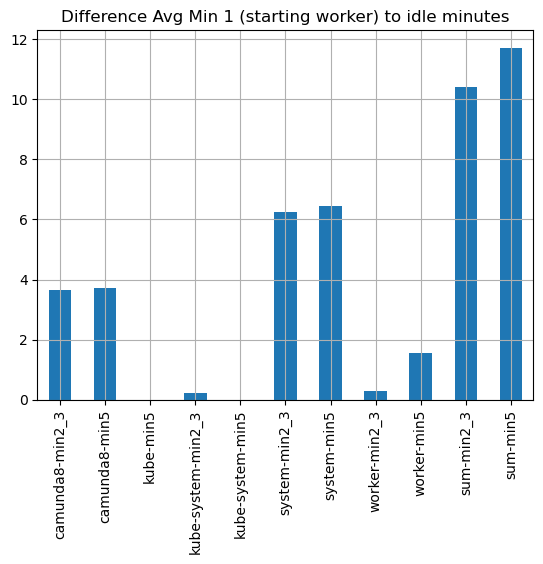

In [92]:
diff_startup_tomin2_3 = (avg_by_min.loc['Min1',:].transpose() - min2_3_avg).add_suffix("-min2_3")
diff_startup_tomin5 = (avg_by_min.loc['Min1',:].transpose() - avg_idle).add_suffix("-min5")

diff_startup = pd.concat([diff_startup_tomin2_3,diff_startup_tomin5])
diff_startup = diff_startup.sort_index(axis=0)
diff_startup['sum-min2_3'] = diff_startup_tomin2_3.sum()
diff_startup['sum-min5'] = diff_startup_tomin5.sum()

diff_startup.plot(kind="bar", grid=True, title="Difference Avg Min 1 (starting worker) to idle minutes")

# Calculating Shutdown

In **Min4**,  the started worker is stopped. Taking **min2_3_avg** and subtracting it from **Min4** should only leave energy needed for starting a worker

<Axes: title={'center': 'Difference Avg Min 4 (stopping worker) to idle minutes'}>

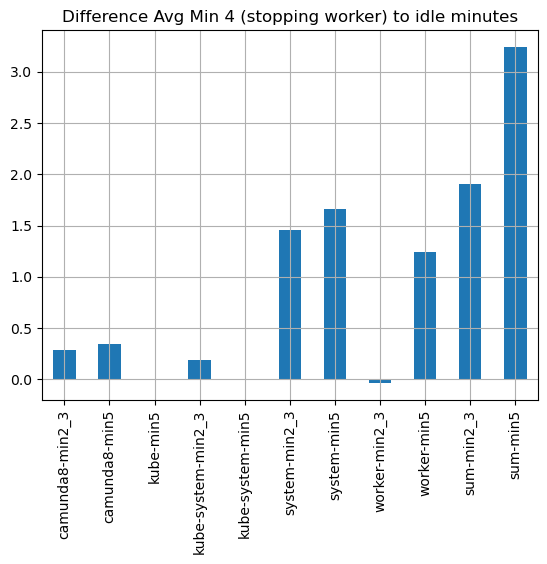

In [93]:
diff_shutdown_tomin2_3 = (avg_by_min.loc['Min4',:].transpose() - min2_3_avg).add_suffix("-min2_3")
diff_shutdown_tomin5 = (avg_by_min.loc['Min4',:].transpose() - avg_idle).add_suffix("-min5")

diff_shutdown = pd.concat([diff_shutdown_tomin2_3,diff_shutdown_tomin5])
diff_shutdown = diff_shutdown.sort_index(axis=0)
diff_shutdown['sum-min2_3'] = diff_shutdown_tomin2_3.sum()
diff_shutdown['sum-min5'] = diff_shutdown_tomin5.sum()

diff_shutdown.plot(kind="bar", grid=True, title="Difference Avg Min 4 (stopping worker) to idle minutes")

In [94]:
# generating key indicators
indicators = pd.Series()

indicators['idle consumption [W/Min]'] = diff_idle['sum']
indicators['startup_cost [W/Min]'] = diff_startup['sum-min2_3']
indicators['shutdown_cost [W/Min]'] = diff_shutdown['sum-min2_3']
indicators['up_and_down_cost [W/Min]'] = indicators['startup_cost [W/Min]'] + indicators['shutdown_cost [W/Min]']
indicators['max_idle_time [Min]'] = indicators['up_and_down_cost [W/Min]'] / indicators['idle consumption [W/Min]']

indicators


idle consumption [W/Min]     1.527369
startup_cost [W/Min]        10.408652
shutdown_cost [W/Min]        1.908374
up_and_down_cost [W/Min]    12.317026
max_idle_time [Min]          8.064214
dtype: float64

# Conclusion

## Idle

1) For namespaces 'system' and 'kube-system', an idling worker has negligible energy impact. 
2) For namespaces 'camunda8' (in these measurements only consisting of 'zeebe' and 'zeebe-gateway') and 'worker' the idle consumption is around **1.4W/min**

## Startup

1) Starting a worker pod has impact for all namespaces
2) For all namespaces combined, the minute the worker is started takes around **9.6W** more than the idle minutes
3) Most energy goes to 'system' (~4W) and 'camunda8' (~5W)

## Shutdown

1) Comparing the minute the worker shuts down to an idle minute, shutting down takes in total around **1.8W** more
2) shutting down mostly takes energy in the 'camunda8' (~0.5W) and 'system' (~1.1W) namespaces

## Putting it together

The sum of shutting down and starting back up is around **11,4W**, surpassing idle consumption after around **8Min**